# Filter scaffold sets to use as input

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/notebooks
running on node: dig28


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Load a dataframe of scaffolds and associated metadata
These scaffolds had AF2 run on them. 

In [3]:
scaffolds = pd.read_csv("/net/shared/scaffolds/pre_scaffold_DB/final_data.csv")

### Setup for plotting

In [4]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Plot metadata to determine cutoffs

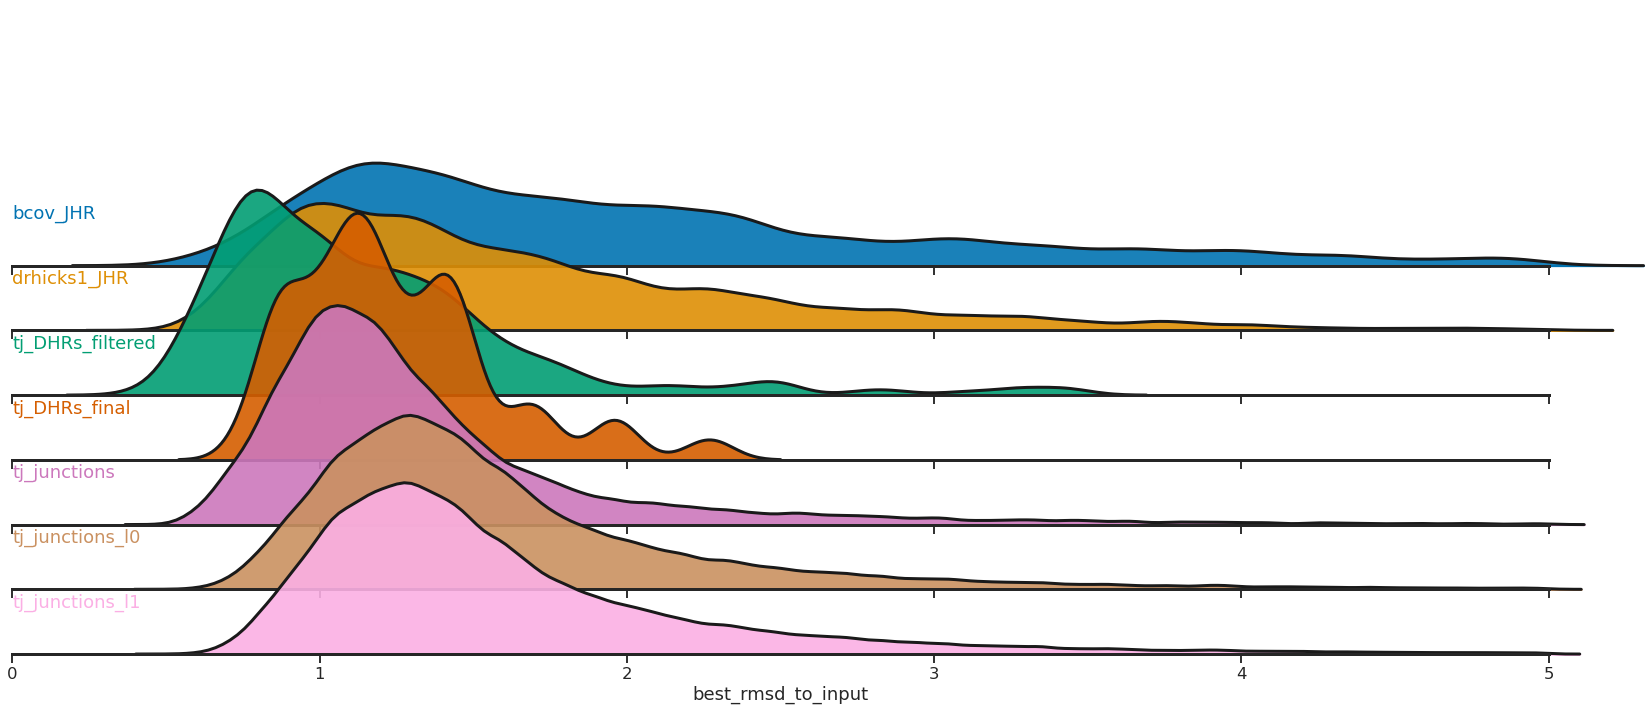

In [5]:
filtered = scaffolds[scaffolds["best_rmsd_to_input"] < 5]  # no crazy outliers
# we only want low contact order, extended, pseudorepetitive helical scaffolds
scaffold_types_allowed = [
    "bcov_JHR",
    "drhicks1_JHR",
    "tj_DHRs_filtered",
    "tj_DHRs_final",
    "tj_junctions",
    "tj_junctions_l0",
    "tj_junctions_l1",
]
scaffold_type_filter = filtered.scaffold_type.isin(scaffold_types_allowed)
filtered = filtered[scaffold_type_filter]
order = sorted(set(filtered.scaffold_type.values))

sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
    rc={"axes.facecolor": (0, 0, 0, 0)},
)

g = sns.FacetGrid(
    filtered,
    row="scaffold_type",
    row_order=order,
    hue="scaffold_type",
    hue_order=order,
    aspect=15,
    height=1.5,
    palette=None,
)

# Draw the densities in a few steps
g.map(
    sns.kdeplot,
    "best_rmsd_to_input",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=0.9,
    linewidth=2,
)
g.map(
    sns.kdeplot,
    "best_rmsd_to_input",
    clip_on=False,
    color="k",
    linewidth=3,
    bw_adjust=0.5,
)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        #         fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label, "best_rmsd_to_input")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.75)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(0.0, 5.0))
for ax in g.axes.flat:
    ax.spines["bottom"].set_linewidth(3)
g.despine(left=True)

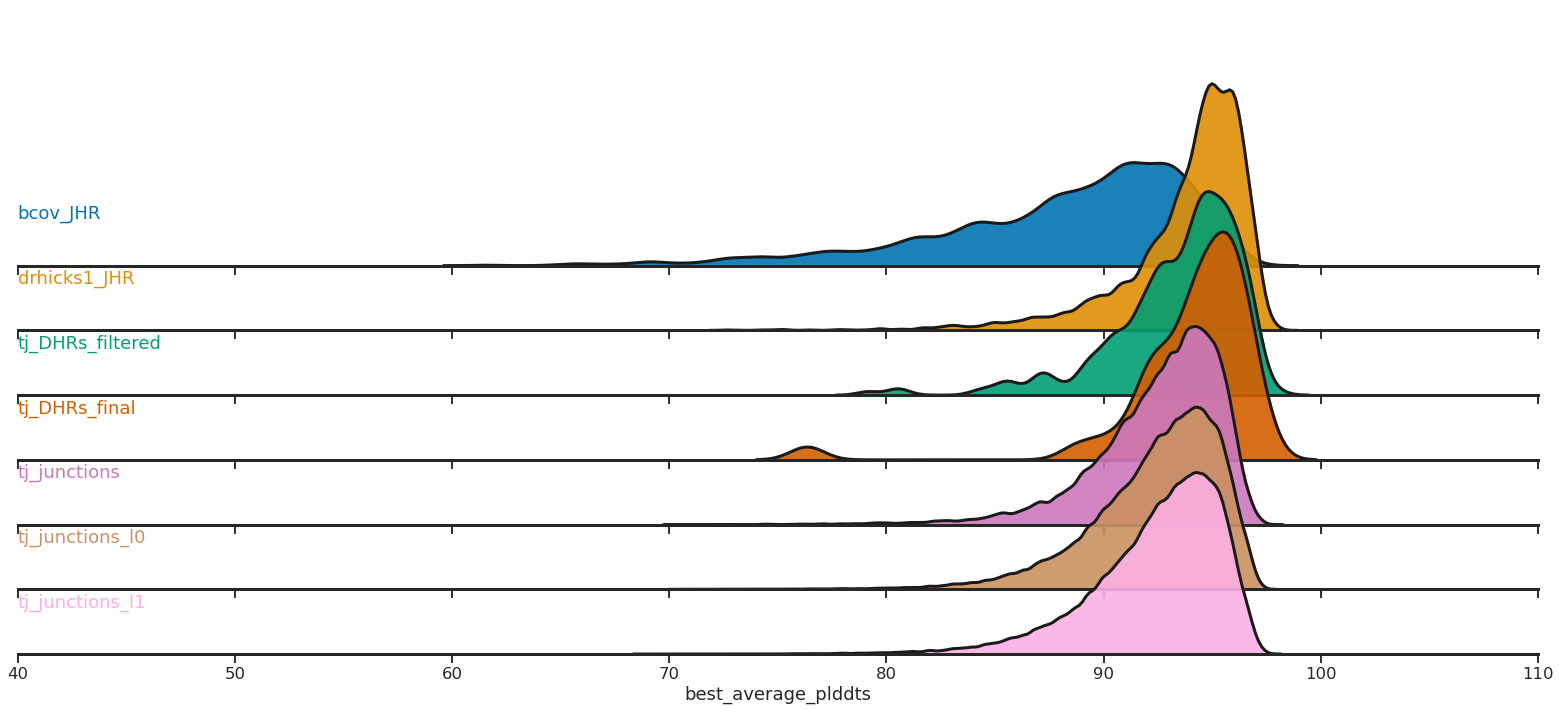

In [6]:
g = sns.FacetGrid(
    filtered,
    row="scaffold_type",
    row_order=order,
    hue="scaffold_type",
    hue_order=order,
    aspect=15,
    height=1.5,
    palette=None,
)

# Draw the densities in a few steps
g.map(
    sns.kdeplot,
    "best_average_plddts",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=0.9,
    linewidth=2,
)
g.map(
    sns.kdeplot,
    "best_average_plddts",
    clip_on=False,
    color="k",
    linewidth=3,
    bw_adjust=0.5,
)

g.map(label, "best_average_plddts")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.75)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(40, 110))
for ax in g.axes.flat:
    ax.spines["bottom"].set_linewidth(3)
g.despine(left=True)

### I think flat cutoffs of < 1.5 RMSD and > 92 plDDT make sense, <1.25 for non DHR inputs
Non DHR inputs are not experimentally validated so we will be stricter.  
The l0 set of tj_junctions is a subset of l1 so we don't need it 

In [7]:
good_inputs = filtered.query(
    "\
    best_rmsd_to_input < 1.5 \
    and best_average_plddts > 92 \
    "
)
good_inputs = good_inputs.query(
    "\
    best_rmsd_to_input <= 1.25 \
    and scaffold_type != 'tj_DHRs_final' \
    and scaffold_type != 'tj_junctions_l0' \
    or scaffold_type == 'tj_DHRs_final' \
    "
)
len(good_inputs)

32266

### Also make a smaller list for pilot experiments
Get all tj_DHRs, but also 20 of the 2 different types of JHR, junctions, and larger DHR set.

In [8]:
dfs_to_concat = []
all_dhrs = good_inputs.query("scaffold_type == 'tj_DHRs_final'")
dfs_to_concat.append(all_dhrs)
for scaffold_type in tqdm(
    [
        "bcov_JHR",
        "drhicks1_JHR",
        "tj_DHRs_filtered",
        "tj_junctions",
        "tj_junctions_l1",
    ]
):
    subset = good_inputs.query("scaffold_type == @scaffold_type")
    sample = subset.sample(n=20, random_state=0)
    dfs_to_concat.append(sample)
test_inputs = pd.concat(dfs_to_concat)
len(test_inputs)

  0%|          | 0/5 [00:00<?, ?it/s]

133

### Make seperate CSVs of the individual designs by parent 

In [9]:
out_path = os.path.join(os.getcwd(), "scaffolds/00_filter_scaffold_sets/")

os.makedirs(out_path, exist_ok=True)

for scaffold_type in tqdm(
    [
        "bcov_JHR",
        "drhicks1_JHR",
        "tj_DHRs_filtered",
        "tj_DHRs_final",
        "tj_junctions",
        "tj_junctions_l1",
    ]
):
    subset = good_inputs.query("scaffold_type == @scaffold_type")
    subset.set_index("pdb", inplace=True)
    subset.to_csv(os.path.join(out_path, f"{scaffold_type}_filtered.csv"))
    with open(os.path.join(out_path, f"{scaffold_type}_filtered.list"), "w") as f:
        for line in subset.index:
            print(line, file=f)

  0%|          | 0/6 [00:00<?, ?it/s]

### Also make a joint CSV of all the inputs and the test inputs

In [10]:
good_inputs.set_index("pdb", inplace=True)
good_inputs.to_csv(os.path.join(out_path, "all_filtered.csv"))
with open(os.path.join(out_path, "all_filtered.list"), "w") as f:
    for line in tqdm(good_inputs.index):
        print(line, file=f)

test_inputs.set_index("pdb", inplace=True)
test_inputs.to_csv(os.path.join(out_path, "test_filtered.csv"))
with open(os.path.join(out_path, "test_filtered.list"), "w") as f:
    for line in tqdm(test_inputs.index):
        print(line, file=f)

  0%|          | 0/32266 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

### Prototyping blocks